In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


In [18]:
# Download baseline at: https://github.com/e-sha/BSTLD_demo/blob/master/models/model.ckpt-128199_proto/frozen_inference_graph.pb

baseline_model_filename ='/work/data/other/BSTLD_demo-master/models/model.ckpt-128199_proto/frozen_inference_graph.pb'

retrained_model_filename ='/work/data/BSTLD/mirror_padding/frozen_inference_graph.pb'

# run using the baseline model
model_filename = baseline_model_filename

with tf.compat.v1.gfile.GFile(model_filename, 'rb') as f:
    graph_def = tf.compat.v1.GraphDef()
    graph_def.ParseFromString(f.read())
with tf.Graph().as_default() as graph:
    tf.import_graph_def(graph_def, name='')


## Script to Shift The Target Object, Each Time Running the SSD

In [4]:
def calculate_iou(box_x, box_y, box_width, box_height, ins_x, ins_y, ins_width, ins_height):

    xA = max(box_x, ins_x)
    yA = max(box_y, ins_y)
    xB = min(box_x + box_width, ins_x + ins_width)
    yB = min(box_y + box_height, ins_y + ins_height)

    # if (ins_x == 0 and ins_y==0):
    #     print(box_x, box_y, box_width, box_height, ins_x, ins_y, ins_width, ins_height)
    #     print(xB-xA, yB-yA)

    interArea = max(xB-xA, 0.0) * max(yB-yA,0.0)
    unionArea = box_width * box_height + ins_width * ins_height - interArea
    return interArea / float(unionArea)

In [5]:
def calc_map(sess, src_img, obj_rect, x_step, y_step, bg_color, debias = False, print_progress = False):

    obj_width = obj_rect[3] - obj_rect[1] + 1
    obj_height = obj_rect[2] - obj_rect[0] + 1

    scoremap_steps = np.zeros([src_img.shape[0], src_img.shape[1]])
    scoremap_unfiltered = np.zeros([src_img.shape[0], src_img.shape[1]])

    image = np.ones([1, src_img.shape[0], src_img.shape[1], src_img.shape[2]]) * bg_color

    for startY in range(0, src_img.shape[0] - y_step+1, y_step):
      for startX in range(0, src_img.shape[1] - x_step+1, x_step):
        
        src_x1 = max(obj_rect[1] - startX, 0)
        src_x2 = src_img.shape[1] -  max(startX -  obj_rect[1], 0)

        src_y1 = max(obj_rect[0] - startY, 0)
        src_y2 = src_img.shape[0] -  max(startY -  obj_rect[0], 0)

        dest_x1 = max(startX - obj_rect[1], 0)
        dest_x2 = src_img.shape[1] -  max(obj_rect[1] - startX, 0)

        dest_y1 = max(startY - obj_rect[0], 0)
        dest_y2 = src_img.shape[0] -  max(obj_rect[0] - startY, 0)

        image[0, dest_y1:dest_y2, dest_x1:dest_x2, :] = src_img[src_y1:src_y2, src_x1:src_x2, :]
        
        
        feed_dict={"image_tensor:0":image} # np.expand_dims(img, 0)
        tensor_dict = {}
        for key in ['num_detections', 'detection_boxes', 'detection_scores', 'detection_classes']:
          tensor_name = key + ':0'
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
        output_dict = sess.run(tensor_dict, feed_dict)


        image[0, dest_y1:dest_y2, dest_x1:dest_x2, :] = bg_color


        boxes = output_dict['detection_boxes'][0]
        scores = output_dict['detection_scores'][0]
        best_iou = 0
        best_score = 0
        matched_iou = 0
        best_box = [0, 0, 0, 0]
        for i in range(len(boxes)):
            top = int(boxes[i][0] * src_img.shape[0])- 3 
            bottom = int(boxes[i][2] * src_img.shape[0]) + 3 
            left = int(boxes[i][1] * src_img.shape[1]) - 3 
            right = int(boxes[i][3] * src_img.shape[1]) + 3 

            iou = calculate_iou(left, top, right-left + 1, bottom - top + 1, 
                    startX - 3, startY - 3, obj_width + 7, obj_height + 7)
            if iou > 0.1:
                best_iou= max(best_iou, iou)
                if best_score < scores[i]:
                    matched_iou = iou
                    best_score = scores[i]
                    best_box = boxes[i]


        scoremap_steps[startY:startY + y_step, startX:startX + x_step] = best_score

        scoremap_unfiltered[startY:startY + y_step, startX:startX + x_step] = scores[0]

        if print_progress:
            print("{} - {}: {} in {}".format(startX, startY, best_score, best_box))

    return scoremap_steps, scoremap_unfiltered




In [11]:
from PIL import Image
img = Image.open("./scene_image.jpeg").convert("RGB")
overlay = img.crop([47, 8, 67, 75]).resize([8, 24]) # RED

img = np.ones([1, 720, 1280, 3]) * 128
img[0][:24, :8, :] = overlay

In [12]:
overlay

## Baseline

In [19]:
with graph.as_default():
  with tf.compat.v1.Session() as sess:
    res_map_bl = calc_map(sess, img[0], [0, 0, 24, 8], 8, 24, 128, print_progress=True)

0 - 0: 0.05405673384666443 in [0.         0.         0.03778585 0.00722401]
8 - 0: 0.11329254508018494 in [0.00014712 0.00152253 0.03378858 0.01201089]
16 - 0: 0.12508660554885864 in [0.         0.00576341 0.03275298 0.01620629]
24 - 0: 0.462943971157074 in [0.0019974  0.01289255 0.03764035 0.02390705]
32 - 0: 0.25303471088409424 in [0.         0.02089968 0.03373671 0.03138409]
40 - 0: 0.4419730603694916 in [0.00142653 0.02823304 0.03498344 0.03794797]
48 - 0: 0.3723394274711609 in [0.00220738 0.03551967 0.03383504 0.04419184]
56 - 0: 0.15684852004051208 in [0.00014359 0.0383623  0.03393199 0.04972728]
64 - 0: 0.23487594723701477 in [0.         0.04358461 0.03138456 0.05346314]
72 - 0: 0.45551156997680664 in [0.00284955 0.05224231 0.03661997 0.06279228]
80 - 0: 0.30248528718948364 in [0.00099343 0.06076765 0.03236614 0.07096119]
88 - 0: 0.3965768814086914 in [0.0006893  0.06661074 0.03404319 0.07619862]
96 - 0: 0.3410896062850952 in [0.00092428 0.07294437 0.03316138 0.08215118]
104 - 0

856 - 0: 0.42235976457595825 in [0.00111735 0.66653687 0.03470951 0.6759756 ]
864 - 0: 0.3669734001159668 in [0.00140481 0.6735602  0.03375626 0.6824731 ]
872 - 0: 0.42235976457595825 in [0.00111735 0.67903686 0.03470951 0.6884756 ]
880 - 0: 0.3669734001159668 in [0.00140481 0.6860602  0.03375626 0.6949731 ]
888 - 0: 0.42235976457595825 in [0.00111735 0.69153684 0.03470951 0.7009756 ]
896 - 0: 0.3669734001159668 in [0.00140481 0.6985602  0.03375626 0.7074731 ]
904 - 0: 0.42235976457595825 in [0.00111735 0.70403683 0.03470951 0.7134756 ]
912 - 0: 0.3669734001159668 in [0.00140481 0.71106017 0.03375626 0.7199731 ]
920 - 0: 0.42235976457595825 in [0.00111735 0.7165368  0.03470951 0.7259756 ]
928 - 0: 0.3669734001159668 in [0.00140481 0.72356015 0.03375626 0.7324731 ]
936 - 0: 0.42235976457595825 in [0.00111735 0.72903687 0.03470951 0.7384756 ]
944 - 0: 0.3669734001159668 in [0.00140481 0.7360602  0.03375626 0.7449731 ]
952 - 0: 0.42235976457595825 in [0.00111735 0.74153686 0.03470951 0.75

416 - 24: 0.7058136463165283 in [0.03065423 0.32402122 0.06758013 0.33240467]
424 - 24: 0.7987527251243591 in [0.0290108  0.3294035  0.06769302 0.33800617]
432 - 24: 0.7058136463165283 in [0.03065423 0.3365212  0.06758013 0.34490466]
440 - 24: 0.7987527251243591 in [0.0290108  0.3419035  0.06769302 0.3505062 ]
448 - 24: 0.7058136463165283 in [0.03065423 0.34902123 0.06758013 0.35740468]
456 - 24: 0.7987527251243591 in [0.0290108  0.3544035  0.06769302 0.36300617]
464 - 24: 0.7058136463165283 in [0.03065423 0.3615212  0.06758013 0.36990467]
472 - 24: 0.7987527251243591 in [0.0290108  0.36690348 0.06769302 0.37550616]
480 - 24: 0.7058136463165283 in [0.03065423 0.3740212  0.06758013 0.38240466]
488 - 24: 0.7987527251243591 in [0.0290108  0.3794035  0.06769302 0.38800618]
496 - 24: 0.7058136463165283 in [0.03065423 0.38652122 0.06758013 0.39490467]
504 - 24: 0.7987527251243591 in [0.0290108  0.3919035  0.06769302 0.40050617]
512 - 24: 0.7058136463165283 in [0.03065423 0.3990212  0.0675801

1264 - 24: 0.7116337418556213 in [0.02940046 0.9860084  0.06687809 0.9944155 ]
1272 - 24: 0.5913223624229431 in [0.02494529 0.9895127  0.07140007 0.99824476]
0 - 48: 0.11230361461639404 in [0.05882063 0.00046905 0.09744505 0.00775624]
8 - 48: 0.4814714789390564 in [0.06166713 0.00445847 0.09744601 0.01374021]
16 - 48: 0.45631423592567444 in [0.06197105 0.00962315 0.09811945 0.0189239 ]
24 - 48: 0.876369059085846 in [0.06172883 0.01729924 0.09990727 0.02616441]
32 - 48: 0.7152584791183472 in [0.06396301 0.02354986 0.09938286 0.03235095]
40 - 48: 0.8501124382019043 in [0.06157487 0.02960072 0.10003568 0.0383791 ]
48 - 48: 0.7286807894706726 in [0.06320514 0.03559794 0.10064009 0.04421154]
56 - 48: 0.8624814748764038 in [0.0608989  0.04268    0.09905767 0.05199253]
64 - 48: 0.7652217745780945 in [0.06237614 0.04766579 0.09914063 0.05666413]
72 - 48: 0.9427611231803894 in [0.06233358 0.05516914 0.10019347 0.06415862]
80 - 48: 0.9219565391540527 in [0.06404974 0.06059748 0.10028937 0.069489

840 - 48: 0.7658728957176208 in [0.06202007 0.6546436  0.10036378 0.663233  ]
848 - 48: 0.6424251198768616 in [0.06347377 0.6609553  0.10055786 0.6694617 ]
856 - 48: 0.7658728957176208 in [0.06202007 0.66714364 0.10036378 0.67573303]
864 - 48: 0.6424251198768616 in [0.06347377 0.67345536 0.10055786 0.6819618 ]
872 - 48: 0.7658728957176208 in [0.06202007 0.67964363 0.10036378 0.688233  ]
880 - 48: 0.6424251198768616 in [0.06347377 0.68595535 0.10055786 0.69446176]
888 - 48: 0.7658728957176208 in [0.06202007 0.6921436  0.10036378 0.700733  ]
896 - 48: 0.6424251198768616 in [0.06347377 0.69845533 0.10055786 0.70696175]
904 - 48: 0.7658728957176208 in [0.06202007 0.7046436  0.10036378 0.713233  ]
912 - 48: 0.6424251198768616 in [0.06347377 0.7109553  0.10055786 0.71946174]
920 - 48: 0.7658728957176208 in [0.06202007 0.7171436  0.10036378 0.725733  ]
928 - 48: 0.6424251198768616 in [0.06347377 0.7234553  0.10055786 0.7319617 ]
936 - 48: 0.7658728957176208 in [0.06202007 0.72964364 0.1003637

408 - 72: 0.17486438155174255 in [0.09589165 0.31659567 0.13534412 0.32539743]
416 - 72: 0.10635426640510559 in [0.09690341 0.32379135 0.13445622 0.33236167]
424 - 72: 0.17486438155174255 in [0.09589165 0.32909566 0.13534412 0.33789742]
432 - 72: 0.10635426640510559 in [0.09690341 0.33629134 0.13445622 0.34486166]
440 - 72: 0.17486438155174255 in [0.09589165 0.34159568 0.13534412 0.35039744]
448 - 72: 0.10635426640510559 in [0.09690341 0.34879136 0.13445622 0.35736167]
456 - 72: 0.17486438155174255 in [0.09589165 0.35409567 0.13534412 0.36289743]
464 - 72: 0.10635426640510559 in [0.09690341 0.36129135 0.13445622 0.36986166]
472 - 72: 0.17486438155174255 in [0.09589165 0.36659566 0.13534412 0.3753974 ]
480 - 72: 0.10635426640510559 in [0.09690341 0.37379134 0.13445622 0.38236165]
488 - 72: 0.17486438155174255 in [0.09589165 0.37909567 0.13534412 0.38789743]
496 - 72: 0.10635426640510559 in [0.09690341 0.38629135 0.13445622 0.39486167]
504 - 72: 0.17486438155174255 in [0.09589165 0.39159

1240 - 72: 0.20947986841201782 in [0.09550757 0.96655554 0.13481954 0.9753991 ]
1248 - 72: 0.08849117159843445 in [0.09637177 0.97374666 0.13390289 0.9823172 ]
1256 - 72: 0.26349055767059326 in [0.09569908 0.97909576 0.13537778 0.9880498 ]
1264 - 72: 0.16270527243614197 in [0.09585101 0.98586583 0.13433436 0.9944891 ]
1272 - 72: 0.34222808480262756 in [0.09323733 0.98976374 0.13725261 0.9982816 ]
0 - 96: 0.021902889013290405 in [0.12737817 0.         0.16654757 0.00635956]
8 - 96: 0.03709402680397034 in [0.12820227 0.00399101 0.16568999 0.01331131]
16 - 96: 0.03484669327735901 in [0.12811366 0.00880526 0.16585624 0.01798754]
24 - 96: 0.04471507668495178 in [0.12923206 0.01705346 0.16818558 0.02605729]
32 - 96: 0.029138565063476562 in [0.13188893 0.02385128 0.16797143 0.03265665]
40 - 96: 0.06735801696777344 in [0.12929282 0.02927674 0.16848186 0.03813242]
48 - 96: 0.043168097734451294 in [0.1302284  0.03552381 0.1687159  0.04427164]
56 - 96: 0.06990423798561096 in [0.12724511 0.0425825

792 - 96: 0.053369492292404175 in [0.12906128 0.61683553 0.16833478 0.6254974 ]
800 - 96: 0.04358360171318054 in [0.13019206 0.6233046  0.16809063 0.6319717 ]
808 - 96: 0.053369492292404175 in [0.12906128 0.6293355  0.16833478 0.6379974 ]
816 - 96: 0.04358360171318054 in [0.13019206 0.6358046  0.16809063 0.6444717 ]
824 - 96: 0.053369492292404175 in [0.12906128 0.6418355  0.16833478 0.6504974 ]
832 - 96: 0.04358360171318054 in [0.13019206 0.6483046  0.16809063 0.6569717 ]
840 - 96: 0.053369492292404175 in [0.12906128 0.6543355  0.16833478 0.66299736]
848 - 96: 0.04358360171318054 in [0.13019206 0.66080457 0.16809063 0.6694717 ]
856 - 96: 0.053369492292404175 in [0.12906128 0.66683555 0.16833478 0.6754974 ]
864 - 96: 0.04358360171318054 in [0.13019206 0.6733046  0.16809063 0.6819717 ]
872 - 96: 0.053369492292404175 in [0.12906128 0.67933553 0.16833478 0.6879974 ]
880 - 96: 0.04358360171318054 in [0.13019206 0.6858046  0.16809063 0.6944717 ]
888 - 96: 0.053369492292404175 in [0.12906128 

344 - 120: 0.704431414604187 in [0.16378635 0.26687235 0.20153102 0.27548146]
352 - 120: 0.48057353496551514 in [0.16462602 0.27331507 0.2006027  0.28181583]
360 - 120: 0.704431414604187 in [0.16378635 0.27937236 0.20153102 0.28798148]
368 - 120: 0.48057353496551514 in [0.16462602 0.2858151  0.2006027  0.29431584]
376 - 120: 0.704431414604187 in [0.16378635 0.29187235 0.20153102 0.30048147]
384 - 120: 0.48057353496551514 in [0.16462602 0.29831508 0.2006027  0.30681583]
392 - 120: 0.704431414604187 in [0.16378635 0.30437234 0.20153102 0.31298146]
400 - 120: 0.48057353496551514 in [0.16462602 0.31081507 0.2006027  0.31931582]
408 - 120: 0.704431414604187 in [0.16378635 0.31687236 0.20153102 0.32548147]
416 - 120: 0.48057353496551514 in [0.16462602 0.32331508 0.2006027  0.33181584]
424 - 120: 0.704431414604187 in [0.16378635 0.32937235 0.20153102 0.33798146]
432 - 120: 0.48057353496551514 in [0.16462602 0.33581507 0.2006027  0.34431583]
440 - 120: 0.704431414604187 in [0.16378635 0.341872

1176 - 120: 0.704431414604187 in [0.16378635 0.9168724  0.20153102 0.92548156]
1184 - 120: 0.48057353496551514 in [0.16462602 0.9233151  0.2006027  0.9318159 ]
1192 - 120: 0.7054351568222046 in [0.16383341 0.92935294 0.20150805 0.93794876]
1200 - 120: 0.49027881026268005 in [0.16468921 0.9358277  0.20059666 0.94431037]
1208 - 120: 0.7382275462150574 in [0.16379276 0.94176185 0.20141861 0.95036376]
1216 - 120: 0.5382336378097534 in [0.16470498 0.948239   0.2004694  0.9567618 ]
1224 - 120: 0.8000138998031616 in [0.1640135  0.9543887  0.20134869 0.96303564]
1232 - 120: 0.5663951635360718 in [0.16491473 0.9606423  0.20053989 0.969214  ]
1240 - 120: 0.7845832109451294 in [0.16318665 0.96682054 0.20079271 0.9755195 ]
1248 - 120: 0.48323750495910645 in [0.1642912  0.9732045  0.20000005 0.98172975]
1256 - 120: 0.7538847923278809 in [0.16327524 0.97936136 0.20147043 0.9881936 ]
1264 - 120: 0.5413867831230164 in [0.16352971 0.98545414 0.20033894 0.99404985]
1272 - 120: 0.5259617567062378 in [0.1

736 - 144: 0.44986391067504883 in [0.19698459 0.5732235  0.2337161  0.58189917]
744 - 144: 0.6827778816223145 in [0.19629227 0.57950234 0.23379152 0.58817077]
752 - 144: 0.44986391067504883 in [0.19698459 0.58572346 0.2337161  0.59439915]
760 - 144: 0.6827778816223145 in [0.19629227 0.59200233 0.23379152 0.60067075]
768 - 144: 0.44986391067504883 in [0.19698459 0.59822345 0.2337161  0.60689914]
776 - 144: 0.6827778816223145 in [0.19629227 0.6045024  0.23379152 0.6131708 ]
784 - 144: 0.44986391067504883 in [0.19698459 0.6107235  0.2337161  0.6193992 ]
792 - 144: 0.6827778816223145 in [0.19629227 0.61700237 0.23379152 0.6256708 ]
800 - 144: 0.44986391067504883 in [0.19698459 0.6232235  0.2337161  0.6318992 ]
808 - 144: 0.6827778816223145 in [0.19629227 0.62950236 0.23379152 0.6381708 ]
816 - 144: 0.44986391067504883 in [0.19698459 0.6357235  0.2337161  0.64439917]
824 - 144: 0.6827778816223145 in [0.19629227 0.64200234 0.23379152 0.65067077]
832 - 144: 0.44986391067504883 in [0.19698459 

288 - 168: 0.48057353496551514 in [0.23129268 0.22331506 0.26726934 0.23181584]
296 - 168: 0.704431414604187 in [0.23045301 0.22937235 0.2681977  0.23798147]
304 - 168: 0.48057353496551514 in [0.23129268 0.23581506 0.26726934 0.24431585]
312 - 168: 0.704431414604187 in [0.23045301 0.24187236 0.2681977  0.2504815 ]
320 - 168: 0.48057353496551514 in [0.23129268 0.24831505 0.26726934 0.25681582]
328 - 168: 0.704431414604187 in [0.23045301 0.25437236 0.2681977  0.26298147]
336 - 168: 0.48057353496551514 in [0.23129268 0.26081505 0.26726934 0.2693158 ]
344 - 168: 0.704431414604187 in [0.23045301 0.26687235 0.2681977  0.27548146]
352 - 168: 0.48057353496551514 in [0.23129268 0.27331507 0.26726934 0.28181583]
360 - 168: 0.704431414604187 in [0.23045301 0.27937236 0.2681977  0.28798148]
368 - 168: 0.48057353496551514 in [0.23129268 0.2858151  0.26726934 0.29431584]
376 - 168: 0.704431414604187 in [0.23045301 0.29187235 0.2681977  0.30048147]
384 - 168: 0.48057353496551514 in [0.23129268 0.2983

1120 - 168: 0.48057353496551514 in [0.23129268 0.8733151  0.26726934 0.8818159 ]
1128 - 168: 0.704431414604187 in [0.23045301 0.87937236 0.2681977  0.88798153]
1136 - 168: 0.48057353496551514 in [0.23129268 0.8858151  0.26726934 0.8943159 ]
1144 - 168: 0.704431414604187 in [0.23045301 0.89187235 0.2681977  0.9004815 ]
1152 - 168: 0.48057353496551514 in [0.23129268 0.8983151  0.26726934 0.9068159 ]
1160 - 168: 0.704431414604187 in [0.23045301 0.90437233 0.2681977  0.9129815 ]
1168 - 168: 0.48057353496551514 in [0.23129268 0.91081506 0.26726934 0.9193159 ]
1176 - 168: 0.704431414604187 in [0.23045301 0.9168724  0.2681977  0.92548156]
1184 - 168: 0.48057353496551514 in [0.23129268 0.9233151  0.26726934 0.9318159 ]
1192 - 168: 0.7054351568222046 in [0.23050007 0.92935294 0.2681747  0.93794876]
1200 - 168: 0.49027881026268005 in [0.23135588 0.9358277  0.26726332 0.94431037]
1208 - 168: 0.7382275462150574 in [0.23045942 0.94176185 0.26808527 0.95036376]
1216 - 168: 0.5382336378097534 in [0.2

672 - 192: 0.44986391067504883 in [0.26365125 0.52322346 0.3003828  0.53189915]
680 - 192: 0.6827778816223145 in [0.26295894 0.52950233 0.3004582  0.53817075]
688 - 192: 0.44986391067504883 in [0.26365125 0.53572345 0.3003828  0.54439914]
696 - 192: 0.6827778816223145 in [0.26295894 0.5420024  0.3004582  0.5506708 ]
704 - 192: 0.44986391067504883 in [0.26365125 0.5482235  0.3003828  0.5568992 ]
712 - 192: 0.6827778816223145 in [0.26295894 0.55450237 0.3004582  0.5631708 ]
720 - 192: 0.44986391067504883 in [0.26365125 0.5607235  0.3003828  0.5693992 ]
728 - 192: 0.6827778816223145 in [0.26295894 0.56700236 0.3004582  0.5756708 ]
736 - 192: 0.44986391067504883 in [0.26365125 0.5732235  0.3003828  0.58189917]
744 - 192: 0.6827778816223145 in [0.26295894 0.57950234 0.3004582  0.58817077]
752 - 192: 0.44986391067504883 in [0.26365125 0.58572346 0.3003828  0.59439915]
760 - 192: 0.6827778816223145 in [0.26295894 0.59200233 0.3004582  0.60067075]
768 - 192: 0.44986391067504883 in [0.26365125 

224 - 216: 0.48057353496551514 in [0.29795936 0.17331506 0.33393607 0.18181585]
232 - 216: 0.704431414604187 in [0.29711968 0.17937236 0.33486438 0.18798147]
240 - 216: 0.48057353496551514 in [0.29795936 0.18581507 0.33393607 0.19431585]
248 - 216: 0.704431414604187 in [0.29711968 0.19187234 0.33486438 0.20048146]
256 - 216: 0.48057353496551514 in [0.29795936 0.19831505 0.33393607 0.20681584]
264 - 216: 0.704431414604187 in [0.29711968 0.20437235 0.33486438 0.21298146]
272 - 216: 0.48057353496551514 in [0.29795936 0.21081506 0.33393607 0.21931584]
280 - 216: 0.704431414604187 in [0.29711968 0.21687235 0.33486438 0.22548147]
288 - 216: 0.48057353496551514 in [0.29795936 0.22331506 0.33393607 0.23181584]
296 - 216: 0.704431414604187 in [0.29711968 0.22937235 0.33486438 0.23798147]
304 - 216: 0.48057353496551514 in [0.29795936 0.23581506 0.33393607 0.24431585]
312 - 216: 0.704431414604187 in [0.29711968 0.24187236 0.33486438 0.2504815 ]
320 - 216: 0.48057353496551514 in [0.29795936 0.2483

1064 - 216: 0.704431414604187 in [0.29711968 0.82937235 0.33486438 0.8379815 ]
1072 - 216: 0.48057353496551514 in [0.29795936 0.8358151  0.33393607 0.8443159 ]
1080 - 216: 0.704431414604187 in [0.29711968 0.84187233 0.33486438 0.8504815 ]
1088 - 216: 0.48057353496551514 in [0.29795936 0.84831506 0.33393607 0.8568159 ]
1096 - 216: 0.704431414604187 in [0.29711968 0.8543724  0.33486438 0.86298156]
1104 - 216: 0.48057353496551514 in [0.29795936 0.8608151  0.33393607 0.8693159 ]
1112 - 216: 0.704431414604187 in [0.29711968 0.8668724  0.33486438 0.87548155]
1120 - 216: 0.48057353496551514 in [0.29795936 0.8733151  0.33393607 0.8818159 ]
1128 - 216: 0.704431414604187 in [0.29711968 0.87937236 0.33486438 0.88798153]
1136 - 216: 0.48057353496551514 in [0.29795936 0.8858151  0.33393607 0.8943159 ]
1144 - 216: 0.704431414604187 in [0.29711968 0.89187235 0.33486438 0.9004815 ]
1152 - 216: 0.48057353496551514 in [0.29795936 0.8983151  0.33393607 0.9068159 ]
1160 - 216: 0.704431414604187 in [0.2971

624 - 240: 0.44986391067504883 in [0.3303179  0.4857234  0.36704946 0.49439916]
632 - 240: 0.6827778816223145 in [0.3296256  0.4920023  0.36712486 0.50067073]
640 - 240: 0.44986391067504883 in [0.3303179  0.4982234  0.36704946 0.5068991 ]
648 - 240: 0.6827778816223145 in [0.3296256  0.50450236 0.36712486 0.5131708 ]
656 - 240: 0.44986391067504883 in [0.3303179  0.5107235  0.36704946 0.51939917]
664 - 240: 0.6827778816223145 in [0.3296256  0.51700234 0.36712486 0.52567077]
672 - 240: 0.44986391067504883 in [0.3303179  0.52322346 0.36704946 0.53189915]
680 - 240: 0.6827778816223145 in [0.3296256  0.52950233 0.36712486 0.53817075]
688 - 240: 0.44986391067504883 in [0.3303179  0.53572345 0.36704946 0.54439914]
696 - 240: 0.6827778816223145 in [0.3296256  0.5420024  0.36712486 0.5506708 ]
704 - 240: 0.44986391067504883 in [0.3303179  0.5482235  0.36704946 0.5568992 ]
712 - 240: 0.6827778816223145 in [0.3296256  0.55450237 0.36712486 0.5631708 ]
720 - 240: 0.44986391067504883 in [0.3303179  

176 - 264: 0.48057353496551514 in [0.36462602 0.13581507 0.40060273 0.14431585]
184 - 264: 0.704431414604187 in [0.36378634 0.14187235 0.40153104 0.15048146]
192 - 264: 0.48057353496551514 in [0.36462602 0.14831506 0.40060273 0.15681584]
200 - 264: 0.704431414604187 in [0.36378634 0.15437235 0.40153104 0.16298147]
208 - 264: 0.48057353496551514 in [0.36462602 0.16081506 0.40060273 0.16931584]
216 - 264: 0.704431414604187 in [0.36378634 0.16687235 0.40153104 0.17548147]
224 - 264: 0.48057353496551514 in [0.36462602 0.17331506 0.40060273 0.18181585]
232 - 264: 0.704431414604187 in [0.36378634 0.17937236 0.40153104 0.18798147]
240 - 264: 0.48057353496551514 in [0.36462602 0.18581507 0.40060273 0.19431585]
248 - 264: 0.704431414604187 in [0.36378634 0.19187234 0.40153104 0.20048146]
256 - 264: 0.48057353496551514 in [0.36462602 0.19831505 0.40060273 0.20681584]
264 - 264: 0.704431414604187 in [0.36378634 0.20437235 0.40153104 0.21298146]
272 - 264: 0.48057353496551514 in [0.36462602 0.2108

1016 - 264: 0.704431414604187 in [0.36378634 0.7918724  0.40153104 0.80048156]
1024 - 264: 0.48057353496551514 in [0.36462602 0.7983151  0.40060273 0.8068159 ]
1032 - 264: 0.704431414604187 in [0.36378634 0.8043724  0.40153104 0.81298155]
1040 - 264: 0.48057353496551514 in [0.36462602 0.8108151  0.40060273 0.8193159 ]
1048 - 264: 0.704431414604187 in [0.36378634 0.81687236 0.40153104 0.82548153]
1056 - 264: 0.48057353496551514 in [0.36462602 0.8233151  0.40060273 0.8318159 ]
1064 - 264: 0.704431414604187 in [0.36378634 0.82937235 0.40153104 0.8379815 ]
1072 - 264: 0.48057353496551514 in [0.36462602 0.8358151  0.40060273 0.8443159 ]
1080 - 264: 0.704431414604187 in [0.36378634 0.84187233 0.40153104 0.8504815 ]
1088 - 264: 0.48057353496551514 in [0.36462602 0.84831506 0.40060273 0.8568159 ]
1096 - 264: 0.704431414604187 in [0.36378634 0.8543724  0.40153104 0.86298156]
1104 - 264: 0.48057353496551514 in [0.36462602 0.8608151  0.40060273 0.8693159 ]
1112 - 264: 0.704431414604187 in [0.3637

576 - 288: 0.44986391067504883 in [0.39698458 0.4482234  0.43371612 0.45689917]
584 - 288: 0.6827778816223145 in [0.39629227 0.4545023  0.43379152 0.46317074]
592 - 288: 0.44986391067504883 in [0.39698458 0.4607234  0.43371612 0.46939915]
600 - 288: 0.6827778816223145 in [0.39629227 0.46700233 0.43379152 0.47567075]
608 - 288: 0.44986391067504883 in [0.39698458 0.47322342 0.43371612 0.48189917]
616 - 288: 0.6827778816223145 in [0.39629227 0.47950232 0.43379152 0.48817074]
624 - 288: 0.44986391067504883 in [0.39698458 0.4857234  0.43371612 0.49439916]
632 - 288: 0.6827778816223145 in [0.39629227 0.4920023  0.43379152 0.50067073]
640 - 288: 0.44986391067504883 in [0.39698458 0.4982234  0.43371612 0.5068991 ]
648 - 288: 0.6827778816223145 in [0.39629227 0.50450236 0.43379152 0.5131708 ]
656 - 288: 0.44986391067504883 in [0.39698458 0.5107235  0.43371612 0.51939917]
664 - 288: 0.6827778816223145 in [0.39629227 0.51700234 0.43379152 0.52567077]
672 - 288: 0.44986391067504883 in [0.39698458 

120 - 312: 0.704431414604187 in [0.430453   0.09187236 0.4681977  0.10048148]
128 - 312: 0.48057353496551514 in [0.43129268 0.09831507 0.4672694  0.10681585]
136 - 312: 0.704431414604187 in [0.430453   0.10437235 0.4681977  0.11298148]
144 - 312: 0.48057353496551514 in [0.43129268 0.11081506 0.4672694  0.11931585]
152 - 312: 0.704431414604187 in [0.430453   0.11687236 0.4681977  0.12548149]
160 - 312: 0.48057353496551514 in [0.43129268 0.12331507 0.4672694  0.13181585]
168 - 312: 0.704431414604187 in [0.430453   0.12937236 0.4681977  0.13798147]
176 - 312: 0.48057353496551514 in [0.43129268 0.13581507 0.4672694  0.14431585]
184 - 312: 0.704431414604187 in [0.430453   0.14187235 0.4681977  0.15048146]
192 - 312: 0.48057353496551514 in [0.43129268 0.14831506 0.4672694  0.15681584]
200 - 312: 0.704431414604187 in [0.430453   0.15437235 0.4681977  0.16298147]
208 - 312: 0.48057353496551514 in [0.43129268 0.16081506 0.4672694  0.16931584]
216 - 312: 0.704431414604187 in [0.430453   0.166872

960 - 312: 0.48057353496551514 in [0.43129268 0.7483151  0.4672694  0.7568159 ]
968 - 312: 0.704431414604187 in [0.430453   0.75437236 0.4681977  0.76298153]
976 - 312: 0.48057353496551514 in [0.43129268 0.7608151  0.4672694  0.7693159 ]
984 - 312: 0.704431414604187 in [0.430453   0.76687235 0.4681977  0.7754815 ]
992 - 312: 0.48057353496551514 in [0.43129268 0.7733151  0.4672694  0.7818159 ]
1000 - 312: 0.704431414604187 in [0.430453   0.77937233 0.4681977  0.7879815 ]
1008 - 312: 0.48057353496551514 in [0.43129268 0.78581506 0.4672694  0.7943159 ]
1016 - 312: 0.704431414604187 in [0.430453   0.7918724  0.4681977  0.80048156]
1024 - 312: 0.48057353496551514 in [0.43129268 0.7983151  0.4672694  0.8068159 ]
1032 - 312: 0.704431414604187 in [0.430453   0.8043724  0.4681977  0.81298155]
1040 - 312: 0.48057353496551514 in [0.43129268 0.8108151  0.4672694  0.8193159 ]
1048 - 312: 0.704431414604187 in [0.430453   0.81687236 0.4681977  0.82548153]
1056 - 312: 0.48057353496551514 in [0.4312926

520 - 336: 0.6827778816223145 in [0.46295893 0.40450233 0.5004582  0.41317075]
528 - 336: 0.44986391067504883 in [0.46365124 0.41072342 0.5003828  0.41939917]
536 - 336: 0.6827778816223145 in [0.46295893 0.41700232 0.5004582  0.42567074]
544 - 336: 0.44986391067504883 in [0.46365124 0.4232234  0.5003828  0.43189916]
552 - 336: 0.6827778816223145 in [0.46295893 0.4295023  0.5004582  0.43817073]
560 - 336: 0.44986391067504883 in [0.46365124 0.4357234  0.5003828  0.44439915]
568 - 336: 0.6827778816223145 in [0.46295893 0.44200233 0.5004582  0.45067075]
576 - 336: 0.44986391067504883 in [0.46365124 0.4482234  0.5003828  0.45689917]
584 - 336: 0.6827778816223145 in [0.46295893 0.4545023  0.5004582  0.46317074]
592 - 336: 0.44986391067504883 in [0.46365124 0.4607234  0.5003828  0.46939915]
600 - 336: 0.6827778816223145 in [0.46295893 0.46700233 0.5004582  0.47567075]
608 - 336: 0.44986391067504883 in [0.46365124 0.47322342 0.5003828  0.48189917]
616 - 336: 0.6827778816223145 in [0.46295893 0

64 - 360: 0.8188729882240295 in [0.49724507 0.04724891 0.53351176 0.05615767]
72 - 360: 0.9247167706489563 in [0.4976069  0.05533701 0.5342948  0.0641358 ]
80 - 360: 0.8839766383171082 in [0.4990888  0.06089167 0.53384024 0.06960107]
88 - 360: 0.818889856338501 in [0.49666533 0.06724263 0.5346937  0.07576499]
96 - 360: 0.5497567057609558 in [0.49795133 0.07322343 0.53418523 0.08169576]
104 - 360: 0.7238244414329529 in [0.49726343 0.07942165 0.53483915 0.08794278]
112 - 360: 0.5028833746910095 in [0.49822566 0.08595368 0.53392434 0.09432263]
120 - 360: 0.704431414604187 in [0.4971197  0.09187236 0.53486437 0.10048148]
128 - 360: 0.48057353496551514 in [0.49795935 0.09831507 0.533936   0.10681585]
136 - 360: 0.704431414604187 in [0.4971197  0.10437235 0.53486437 0.11298148]
144 - 360: 0.48057353496551514 in [0.49795935 0.11081506 0.533936   0.11931585]
152 - 360: 0.704431414604187 in [0.4971197  0.11687236 0.53486437 0.12548149]
160 - 360: 0.48057353496551514 in [0.49795935 0.12331507 0.

904 - 360: 0.704431414604187 in [0.4971197  0.70437235 0.53486437 0.7129815 ]
912 - 360: 0.48057353496551514 in [0.49795935 0.7108151  0.533936   0.7193159 ]
920 - 360: 0.704431414604187 in [0.4971197  0.71687233 0.53486437 0.7254815 ]
928 - 360: 0.48057353496551514 in [0.49795935 0.72331506 0.533936   0.7318159 ]
936 - 360: 0.704431414604187 in [0.4971197  0.7293724  0.53486437 0.73798156]
944 - 360: 0.48057353496551514 in [0.49795935 0.7358151  0.533936   0.7443159 ]
952 - 360: 0.704431414604187 in [0.4971197  0.7418724  0.53486437 0.75048155]
960 - 360: 0.48057353496551514 in [0.49795935 0.7483151  0.533936   0.7568159 ]
968 - 360: 0.704431414604187 in [0.4971197  0.75437236 0.53486437 0.76298153]
976 - 360: 0.48057353496551514 in [0.49795935 0.7608151  0.533936   0.7693159 ]
984 - 360: 0.704431414604187 in [0.4971197  0.76687235 0.53486437 0.7754815 ]
992 - 360: 0.48057353496551514 in [0.49795935 0.7733151  0.533936   0.7818159 ]
1000 - 360: 0.704431414604187 in [0.4971197  0.77937

456 - 384: 0.6827778816223145 in [0.52962565 0.35450232 0.56712496 0.36317074]
464 - 384: 0.44986391067504883 in [0.530318   0.3607234  0.5670495  0.36939916]
472 - 384: 0.6827778816223145 in [0.52962565 0.3670023  0.56712496 0.37567073]
480 - 384: 0.44986391067504883 in [0.530318   0.3732234  0.5670495  0.38189915]
488 - 384: 0.6827778816223145 in [0.52962565 0.37950233 0.56712496 0.38817075]
496 - 384: 0.44986391067504883 in [0.530318   0.3857234  0.5670495  0.39439917]
504 - 384: 0.6827778816223145 in [0.52962565 0.3920023  0.56712496 0.40067074]
512 - 384: 0.44986391067504883 in [0.530318   0.3982234  0.5670495  0.40689915]
520 - 384: 0.6827778816223145 in [0.52962565 0.40450233 0.56712496 0.41317075]
528 - 384: 0.44986391067504883 in [0.530318   0.41072342 0.5670495  0.41939917]
536 - 384: 0.6827778816223145 in [0.52962565 0.41700232 0.56712496 0.42567074]
544 - 384: 0.44986391067504883 in [0.530318   0.4232234  0.5670495  0.43189916]
552 - 384: 0.6827778816223145 in [0.52962565 0

8 - 408: 0.4969872534275055 in [0.56230533 0.00405003 0.6020508  0.01310054]
16 - 408: 0.6746132373809814 in [0.5628592  0.00886752 0.599867   0.01777542]
24 - 408: 0.8982535600662231 in [0.5644847  0.0168735  0.6016284  0.02556834]
32 - 408: 0.7183323502540588 in [0.5661471  0.02389252 0.600657   0.03257194]
40 - 408: 0.8529070615768433 in [0.5640412  0.02892986 0.60216373 0.03771325]
48 - 408: 0.7783070206642151 in [0.5649143  0.03554858 0.60157627 0.04420982]
56 - 408: 0.8911439180374146 in [0.5640243  0.04290404 0.60180914 0.05184767]
64 - 408: 0.8188729882240295 in [0.5639118  0.04724891 0.6001785  0.05615767]
72 - 408: 0.9247167706489563 in [0.56427366 0.05533701 0.6009615  0.0641358 ]
80 - 408: 0.8839766383171082 in [0.56575555 0.06089167 0.60050696 0.06960107]
88 - 408: 0.818889856338501 in [0.5633321  0.06724263 0.60136044 0.07576499]
96 - 408: 0.5497567057609558 in [0.56461805 0.07322343 0.60085195 0.08169576]
104 - 408: 0.7238244414329529 in [0.56393015 0.07942165 0.6015059 

840 - 408: 0.704431414604187 in [0.56378645 0.65437233 0.6015311  0.6629815 ]
848 - 408: 0.48057353496551514 in [0.5646261  0.66081506 0.60060275 0.6693159 ]
856 - 408: 0.704431414604187 in [0.56378645 0.6668724  0.6015311  0.67548156]
864 - 408: 0.48057353496551514 in [0.5646261  0.6733151  0.60060275 0.6818159 ]
872 - 408: 0.704431414604187 in [0.56378645 0.6793724  0.6015311  0.68798155]
880 - 408: 0.48057353496551514 in [0.5646261  0.6858151  0.60060275 0.6943159 ]
888 - 408: 0.704431414604187 in [0.56378645 0.69187236 0.6015311  0.70048153]
896 - 408: 0.48057353496551514 in [0.5646261  0.6983151  0.60060275 0.7068159 ]
904 - 408: 0.704431414604187 in [0.56378645 0.70437235 0.6015311  0.7129815 ]
912 - 408: 0.48057353496551514 in [0.5646261  0.7108151  0.60060275 0.7193159 ]
920 - 408: 0.704431414604187 in [0.56378645 0.71687233 0.6015311  0.7254815 ]
928 - 408: 0.48057353496551514 in [0.5646261  0.72331506 0.60060275 0.7318159 ]
936 - 408: 0.704431414604187 in [0.56378645 0.729372

392 - 432: 0.6827778816223145 in [0.5962923  0.3045023  0.6337916  0.31317073]
400 - 432: 0.44986391067504883 in [0.5969847  0.3107234  0.63371617 0.31939915]
408 - 432: 0.6827778816223145 in [0.5962923  0.31700233 0.6337916  0.32567075]
416 - 432: 0.44986391067504883 in [0.5969847  0.3232234  0.63371617 0.33189917]
424 - 432: 0.6827778816223145 in [0.5962923  0.3295023  0.6337916  0.33817074]
432 - 432: 0.44986391067504883 in [0.5969847  0.3357234  0.63371617 0.34439915]
440 - 432: 0.6827778816223145 in [0.5962923  0.34200233 0.6337916  0.35067075]
448 - 432: 0.44986391067504883 in [0.5969847  0.34822342 0.63371617 0.35689917]
456 - 432: 0.6827778816223145 in [0.5962923  0.35450232 0.6337916  0.36317074]
464 - 432: 0.44986391067504883 in [0.5969847  0.3607234  0.63371617 0.36939916]
472 - 432: 0.6827778816223145 in [0.5962923  0.3670023  0.6337916  0.37567073]
480 - 432: 0.44986391067504883 in [0.5969847  0.3732234  0.63371617 0.38189915]
488 - 432: 0.6827778816223145 in [0.5962923  0

1224 - 432: 0.7486027479171753 in [0.59659016 0.9545923  0.6336608  0.9632911 ]
1232 - 432: 0.5896482467651367 in [0.5975892  0.96076846 0.63363904 0.9693614 ]
1240 - 432: 0.7700753808021545 in [0.59632736 0.9671154  0.63348943 0.9758012 ]
1248 - 432: 0.4803082346916199 in [0.59668666 0.9734843  0.6329703  0.98208034]
1256 - 432: 0.7981728911399841 in [0.59556586 0.9795222  0.6334284  0.9882852 ]
1264 - 432: 0.6109141707420349 in [0.5964809  0.9853763  0.63346523 0.9941192 ]
1272 - 432: 0.33032160997390747 in [0.5901012  0.99083424 0.6347149  0.9996036 ]
0 - 456: 0.15186575055122375 in [0.6284818  0.         0.66922945 0.00639554]
8 - 456: 0.4969872534275055 in [0.628972   0.00405003 0.66871744 0.01310054]
16 - 456: 0.6746132373809814 in [0.62952584 0.00886752 0.66653365 0.01777542]
24 - 456: 0.8982535600662231 in [0.6311514  0.0168735  0.6682951  0.02556834]
32 - 456: 0.7183323502540588 in [0.6328138  0.02389252 0.6673237  0.03257194]
40 - 456: 0.8529070615768433 in [0.63070786 0.0289

776 - 456: 0.704431414604187 in [0.6304531  0.6043724  0.66819775 0.61298156]
784 - 456: 0.48057353496551514 in [0.63129276 0.6108151  0.6672694  0.6193159 ]
792 - 456: 0.704431414604187 in [0.6304531  0.6168724  0.66819775 0.62548155]
800 - 456: 0.48057353496551514 in [0.63129276 0.6233151  0.6672694  0.6318159 ]
808 - 456: 0.704431414604187 in [0.6304531  0.62937236 0.66819775 0.63798153]
816 - 456: 0.48057353496551514 in [0.63129276 0.6358151  0.6672694  0.6443159 ]
824 - 456: 0.704431414604187 in [0.6304531  0.64187235 0.66819775 0.6504815 ]
832 - 456: 0.48057353496551514 in [0.63129276 0.6483151  0.6672694  0.6568159 ]
840 - 456: 0.704431414604187 in [0.6304531  0.65437233 0.66819775 0.6629815 ]
848 - 456: 0.48057353496551514 in [0.63129276 0.66081506 0.6672694  0.6693159 ]
856 - 456: 0.704431414604187 in [0.6304531  0.6668724  0.66819775 0.67548156]
864 - 456: 0.48057353496551514 in [0.63129276 0.6733151  0.6672694  0.6818159 ]
872 - 456: 0.704431414604187 in [0.6304531  0.679372

328 - 480: 0.6827778816223145 in [0.662959   0.2545023  0.7004583  0.26317072]
336 - 480: 0.44986391067504883 in [0.66365135 0.2607234  0.7003828  0.26939917]
344 - 480: 0.6827778816223145 in [0.662959   0.2670023  0.7004583  0.27567074]
352 - 480: 0.44986391067504883 in [0.66365135 0.2732234  0.7003828  0.28189915]
360 - 480: 0.6827778816223145 in [0.662959   0.27950233 0.7004583  0.28817075]
368 - 480: 0.44986391067504883 in [0.66365135 0.28572342 0.7003828  0.29439917]
376 - 480: 0.6827778816223145 in [0.662959   0.29200232 0.7004583  0.30067074]
384 - 480: 0.44986391067504883 in [0.66365135 0.2982234  0.7003828  0.30689916]
392 - 480: 0.6827778816223145 in [0.662959   0.3045023  0.7004583  0.31317073]
400 - 480: 0.44986391067504883 in [0.66365135 0.3107234  0.7003828  0.31939915]
408 - 480: 0.6827778816223145 in [0.662959   0.31700233 0.7004583  0.32567075]
416 - 480: 0.44986391067504883 in [0.66365135 0.3232234  0.7003828  0.33189917]
424 - 480: 0.6827778816223145 in [0.662959   0

1160 - 480: 0.6827778816223145 in [0.662959   0.90450233 0.7004583  0.91317075]
1168 - 480: 0.44986391067504883 in [0.66365135 0.91072345 0.7003828  0.91939914]
1176 - 480: 0.6827778816223145 in [0.662959  0.9170024 0.7004583 0.9256708]
1184 - 480: 0.44986391067504883 in [0.66365135 0.9232235  0.7003828  0.9318992 ]
1192 - 480: 0.6824005842208862 in [0.6630104  0.9294757  0.70045215 0.93813545]
1200 - 480: 0.4589226543903351 in [0.663753   0.9357416  0.70038646 0.944388  ]
1208 - 480: 0.6930572986602783 in [0.6632002  0.94192225 0.70051223 0.95058054]
1216 - 480: 0.496630996465683 in [0.66404724 0.94822866 0.7004454  0.95685714]
1224 - 480: 0.7486027479171753 in [0.6632568  0.9545923  0.70032746 0.9632911 ]
1232 - 480: 0.5896482467651367 in [0.66425586 0.96076846 0.7003057  0.9693614 ]
1240 - 480: 0.7700753808021545 in [0.662994  0.9671154 0.7001561 0.9758012]
1248 - 480: 0.4803082346916199 in [0.6633533  0.9734843  0.69963694 0.98208034]
1256 - 480: 0.7981728911399841 in [0.6622325  0

720 - 504: 0.48057353496551514 in [0.6979594 0.5608151 0.7339361 0.5693159]
728 - 504: 0.704431414604187 in [0.6971198  0.56687236 0.7348644  0.57548153]
736 - 504: 0.48057353496551514 in [0.6979594 0.5733151 0.7339361 0.5818159]
744 - 504: 0.704431414604187 in [0.6971198  0.57937235 0.7348644  0.5879815 ]
752 - 504: 0.48057353496551514 in [0.6979594 0.5858151 0.7339361 0.5943159]
760 - 504: 0.704431414604187 in [0.6971198  0.59187233 0.7348644  0.6004815 ]
768 - 504: 0.48057353496551514 in [0.6979594  0.59831506 0.7339361  0.6068159 ]
776 - 504: 0.704431414604187 in [0.6971198  0.6043724  0.7348644  0.61298156]
784 - 504: 0.48057353496551514 in [0.6979594 0.6108151 0.7339361 0.6193159]
792 - 504: 0.704431414604187 in [0.6971198  0.6168724  0.7348644  0.62548155]
800 - 504: 0.48057353496551514 in [0.6979594 0.6233151 0.7339361 0.6318159]
808 - 504: 0.704431414604187 in [0.6971198  0.62937236 0.7348644  0.63798153]
816 - 504: 0.48057353496551514 in [0.6979594 0.6358151 0.7339361 0.64431

288 - 528: 0.44986391067504883 in [0.730318   0.2232234  0.7670495  0.23189916]
296 - 528: 0.6827778816223145 in [0.72962564 0.22950232 0.76712495 0.23817074]
304 - 528: 0.44986391067504883 in [0.730318   0.2357234  0.7670495  0.24439916]
312 - 528: 0.6827778816223145 in [0.72962564 0.24200232 0.76712495 0.25067076]
320 - 528: 0.44986391067504883 in [0.730318   0.24822342 0.7670495  0.25689918]
328 - 528: 0.6827778816223145 in [0.72962564 0.2545023  0.76712495 0.26317072]
336 - 528: 0.44986391067504883 in [0.730318   0.2607234  0.7670495  0.26939917]
344 - 528: 0.6827778816223145 in [0.72962564 0.2670023  0.76712495 0.27567074]
352 - 528: 0.44986391067504883 in [0.730318   0.2732234  0.7670495  0.28189915]
360 - 528: 0.6827778816223145 in [0.72962564 0.27950233 0.76712495 0.28817075]
368 - 528: 0.44986391067504883 in [0.730318   0.28572342 0.7670495  0.29439917]
376 - 528: 0.6827778816223145 in [0.72962564 0.29200232 0.76712495 0.30067074]
384 - 528: 0.44986391067504883 in [0.730318   

1120 - 528: 0.44986391067504883 in [0.730318  0.8732235 0.7670495 0.8818992]
1128 - 528: 0.6827778816223145 in [0.72962564 0.87950236 0.76712495 0.8881708 ]
1136 - 528: 0.44986391067504883 in [0.730318   0.8857235  0.7670495  0.89439917]
1144 - 528: 0.6827778816223145 in [0.72962564 0.89200234 0.76712495 0.90067077]
1152 - 528: 0.44986391067504883 in [0.730318   0.89822346 0.7670495  0.90689915]
1160 - 528: 0.6827778816223145 in [0.72962564 0.90450233 0.76712495 0.91317075]
1168 - 528: 0.44986391067504883 in [0.730318   0.91072345 0.7670495  0.91939914]
1176 - 528: 0.6827778816223145 in [0.72962564 0.9170024  0.76712495 0.9256708 ]
1184 - 528: 0.44986391067504883 in [0.730318  0.9232235 0.7670495 0.9318992]
1192 - 528: 0.6824005842208862 in [0.7296771  0.9294757  0.7671188  0.93813545]
1200 - 528: 0.4589226543903351 in [0.73041964 0.9357416  0.7670531  0.944388  ]
1208 - 528: 0.6930572986602783 in [0.72986686 0.94192225 0.7671789  0.95058054]
1216 - 528: 0.496630996465683 in [0.7307139

672 - 552: 0.48057353496551514 in [0.7646261  0.5233151  0.80060273 0.5318159 ]
680 - 552: 0.704431414604187 in [0.76378644 0.52937233 0.8015311  0.5379815 ]
688 - 552: 0.48057353496551514 in [0.7646261  0.53581506 0.80060273 0.5443159 ]
696 - 552: 0.704431414604187 in [0.76378644 0.5418724  0.8015311  0.55048156]
704 - 552: 0.48057353496551514 in [0.7646261  0.5483151  0.80060273 0.5568159 ]
712 - 552: 0.704431414604187 in [0.76378644 0.5543724  0.8015311  0.56298155]
720 - 552: 0.48057353496551514 in [0.7646261  0.5608151  0.80060273 0.5693159 ]
728 - 552: 0.704431414604187 in [0.76378644 0.56687236 0.8015311  0.57548153]
736 - 552: 0.48057353496551514 in [0.7646261  0.5733151  0.80060273 0.5818159 ]
744 - 552: 0.704431414604187 in [0.76378644 0.57937235 0.8015311  0.5879815 ]
752 - 552: 0.48057353496551514 in [0.7646261  0.5858151  0.80060273 0.5943159 ]
760 - 552: 0.704431414604187 in [0.76378644 0.59187233 0.8015311  0.6004815 ]
768 - 552: 0.48057353496551514 in [0.7646261  0.5983

224 - 576: 0.44986391067504883 in [0.7969847  0.1732234  0.83371615 0.18189916]
232 - 576: 0.6827778816223145 in [0.7962923  0.17950232 0.8337916  0.18817075]
240 - 576: 0.44986391067504883 in [0.7969847  0.18572341 0.83371615 0.19439916]
248 - 576: 0.6827778816223145 in [0.7962923  0.19200231 0.8337916  0.20067073]
256 - 576: 0.44986391067504883 in [0.7969847  0.1982234  0.83371615 0.20689915]
264 - 576: 0.6827778816223145 in [0.7962923  0.20450231 0.8337916  0.21317074]
272 - 576: 0.44986391067504883 in [0.7969847  0.2107234  0.83371615 0.21939915]
280 - 576: 0.6827778816223145 in [0.7962923  0.21700232 0.8337916  0.22567074]
288 - 576: 0.44986391067504883 in [0.7969847  0.2232234  0.83371615 0.23189916]
296 - 576: 0.6827778816223145 in [0.7962923  0.22950232 0.8337916  0.23817074]
304 - 576: 0.44986391067504883 in [0.7969847  0.2357234  0.83371615 0.24439916]
312 - 576: 0.6827778816223145 in [0.7962923  0.24200232 0.8337916  0.25067076]
320 - 576: 0.44986391067504883 in [0.7969847  

1072 - 576: 0.44986391067504883 in [0.7969847  0.83572346 0.83371615 0.84439915]
1080 - 576: 0.6827778816223145 in [0.7962923  0.84200233 0.8337916  0.85067075]
1088 - 576: 0.44986391067504883 in [0.7969847  0.84822345 0.83371615 0.85689914]
1096 - 576: 0.6827778816223145 in [0.7962923 0.8545024 0.8337916 0.8631708]
1104 - 576: 0.44986391067504883 in [0.7969847  0.8607235  0.83371615 0.8693992 ]
1112 - 576: 0.6827778816223145 in [0.7962923  0.86700237 0.8337916  0.8756708 ]
1120 - 576: 0.44986391067504883 in [0.7969847  0.8732235  0.83371615 0.8818992 ]
1128 - 576: 0.6827778816223145 in [0.7962923  0.87950236 0.8337916  0.8881708 ]
1136 - 576: 0.44986391067504883 in [0.7969847  0.8857235  0.83371615 0.89439917]
1144 - 576: 0.6827778816223145 in [0.7962923  0.89200234 0.8337916  0.90067077]
1152 - 576: 0.44986391067504883 in [0.7969847  0.89822346 0.83371615 0.90689915]
1160 - 576: 0.6827778816223145 in [0.7962923  0.90450233 0.8337916  0.91317075]
1168 - 576: 0.44986391067504883 in [0.

632 - 600: 0.704431414604187 in [0.8304531  0.49187234 0.86819774 0.5004815 ]
640 - 600: 0.48057353496551514 in [0.83129275 0.49831507 0.8672694  0.50681585]
648 - 600: 0.704431414604187 in [0.8304531  0.50437236 0.86819774 0.51298153]
656 - 600: 0.48057353496551514 in [0.83129275 0.5108151  0.8672694  0.5193159 ]
664 - 600: 0.704431414604187 in [0.8304531  0.51687235 0.86819774 0.5254815 ]
672 - 600: 0.48057353496551514 in [0.83129275 0.5233151  0.8672694  0.5318159 ]
680 - 600: 0.704431414604187 in [0.8304531  0.52937233 0.86819774 0.5379815 ]
688 - 600: 0.48057353496551514 in [0.83129275 0.53581506 0.8672694  0.5443159 ]
696 - 600: 0.704431414604187 in [0.8304531  0.5418724  0.86819774 0.55048156]
704 - 600: 0.48057353496551514 in [0.83129275 0.5483151  0.8672694  0.5568159 ]
712 - 600: 0.704431414604187 in [0.8304531  0.5543724  0.86819774 0.56298155]
720 - 600: 0.48057353496551514 in [0.83129275 0.5608151  0.8672694  0.5693159 ]
728 - 600: 0.704431414604187 in [0.8304531  0.566872

192 - 624: 0.42143750190734863 in [0.86419624 0.14820512 0.90041393 0.15689804]
200 - 624: 0.6857235431671143 in [0.8636129  0.15453014 0.90035176 0.16319954]
208 - 624: 0.42143750190734863 in [0.86419624 0.16070512 0.90041393 0.16939804]
216 - 624: 0.6857235431671143 in [0.8636129  0.16703014 0.90035176 0.17569955]
224 - 624: 0.42143750190734863 in [0.86419624 0.17320512 0.90041393 0.18189804]
232 - 624: 0.6857235431671143 in [0.8636129  0.17953014 0.90035176 0.18819955]
240 - 624: 0.42143750190734863 in [0.86419624 0.18570513 0.90041393 0.19439805]
248 - 624: 0.6857235431671143 in [0.8636129  0.19203013 0.90035176 0.20069954]
256 - 624: 0.42143750190734863 in [0.86419624 0.19820511 0.90041393 0.20689803]
264 - 624: 0.6857235431671143 in [0.8636129  0.20453013 0.90035176 0.21319954]
272 - 624: 0.42143750190734863 in [0.86419624 0.21070512 0.90041393 0.21939804]
280 - 624: 0.6857235431671143 in [0.8636129  0.21703014 0.90035176 0.22569954]
288 - 624: 0.42143750190734863 in [0.86419624 

1024 - 624: 0.42143750190734863 in [0.86419624 0.7982052  0.90041393 0.80689806]
1032 - 624: 0.6857235431671143 in [0.8636129  0.8045302  0.90035176 0.8131996 ]
1040 - 624: 0.42143750190734863 in [0.86419624 0.8107052  0.90041393 0.81939805]
1048 - 624: 0.6857235431671143 in [0.8636129  0.8170302  0.90035176 0.82569957]
1056 - 624: 0.42143750190734863 in [0.86419624 0.8232052  0.90041393 0.83189803]
1064 - 624: 0.6857235431671143 in [0.8636129  0.8295302  0.90035176 0.83819956]
1072 - 624: 0.42143750190734863 in [0.86419624 0.83570516 0.90041393 0.844398  ]
1080 - 624: 0.6857235431671143 in [0.8636129  0.84203017 0.90035176 0.85069954]
1088 - 624: 0.42143750190734863 in [0.86419624 0.84820515 0.90041393 0.856898  ]
1096 - 624: 0.6857235431671143 in [0.8636129  0.8545302  0.90035176 0.8631996 ]
1104 - 624: 0.42143750190734863 in [0.86419624 0.8607052  0.90041393 0.86939806]
1112 - 624: 0.6857235431671143 in [0.8636129  0.8670302  0.90035176 0.8756996 ]
1120 - 624: 0.42143750190734863 in

584 - 648: 0.7848635911941528 in [0.8986851  0.45435378 0.93408585 0.4631138 ]
592 - 648: 0.4807562530040741 in [0.89899236 0.4606762  0.9335106  0.46938324]
600 - 648: 0.7848635911941528 in [0.8986851  0.4668538  0.93408585 0.47561383]
608 - 648: 0.4807562530040741 in [0.89899236 0.4731762  0.9335106  0.48188326]
616 - 648: 0.7848635911941528 in [0.8986851  0.4793538  0.93408585 0.48811382]
624 - 648: 0.4807562530040741 in [0.89899236 0.4856762  0.9335106  0.49438325]
632 - 648: 0.7848635911941528 in [0.8986851  0.49185377 0.93408585 0.5006138 ]
640 - 648: 0.4807562530040741 in [0.89899236 0.49817622 0.9335106  0.50688326]
648 - 648: 0.7848635911941528 in [0.8986851  0.5043539  0.93408585 0.51311386]
656 - 648: 0.4807562530040741 in [0.89899236 0.51067626 0.9335106  0.5193833 ]
664 - 648: 0.7848635911941528 in [0.8986851  0.51685387 0.93408585 0.52561384]
672 - 648: 0.4807562530040741 in [0.89899236 0.52317625 0.9335106  0.5318833 ]
680 - 648: 0.7848635911941528 in [0.8986851  0.52935

136 - 672: 0.5081349611282349 in [0.93132114 0.104436   0.9666014  0.11290385]
144 - 672: 0.2998896837234497 in [0.93351316 0.10829768 0.9705452  0.11676239]
152 - 672: 0.5081349611282349 in [0.93132114 0.116936   0.9666014  0.12540385]
160 - 672: 0.2998896837234497 in [0.93351316 0.12079769 0.9705452  0.12926239]
168 - 672: 0.5081349611282349 in [0.93132114 0.129436   0.9666014  0.13790385]
176 - 672: 0.2998896837234497 in [0.93351316 0.13329768 0.9705452  0.1417624 ]
184 - 672: 0.5081349611282349 in [0.93132114 0.14193599 0.9666014  0.15040384]
192 - 672: 0.2998896837234497 in [0.93351316 0.14579767 0.9705452  0.1542624 ]
200 - 672: 0.5081349611282349 in [0.93132114 0.15443599 0.9666014  0.16290385]
208 - 672: 0.2998896837234497 in [0.93351316 0.15829769 0.9705452  0.16676238]
216 - 672: 0.5081349611282349 in [0.93132114 0.166936   0.9666014  0.17540385]
224 - 672: 0.2998896837234497 in [0.93351316 0.17079768 0.9705452  0.1792624 ]
232 - 672: 0.5081349611282349 in [0.93132114 0.17943

968 - 672: 0.5081349611282349 in [0.93132114 0.7544361  0.9666014  0.76290387]
976 - 672: 0.2998896837234497 in [0.93351316 0.75829774 0.9705452  0.76676244]
984 - 672: 0.5081349611282349 in [0.93132114 0.76693606 0.9666014  0.77540386]
992 - 672: 0.2998896837234497 in [0.93351316 0.7707977  0.9705452  0.7792624 ]
1000 - 672: 0.5081349611282349 in [0.93132114 0.77943605 0.9666014  0.78790385]
1008 - 672: 0.2998896837234497 in [0.93351316 0.7832977  0.9705452  0.7917624 ]
1016 - 672: 0.5081349611282349 in [0.93132114 0.7919361  0.9666014  0.8004039 ]
1024 - 672: 0.2998896837234497 in [0.93351316 0.79579777 0.9705452  0.80426246]
1032 - 672: 0.5081349611282349 in [0.93132114 0.8044361  0.9666014  0.8129039 ]
1040 - 672: 0.2998896837234497 in [0.93351316 0.80829775 0.9705452  0.81676245]
1048 - 672: 0.5081349611282349 in [0.93132114 0.8169361  0.9666014  0.82540387]
1056 - 672: 0.2998896837234497 in [0.93351316 0.82079774 0.9705452  0.82926244]
1064 - 672: 0.5081349611282349 in [0.9313211

528 - 696: 0.6010681390762329 in [0.9655759  0.4105309  0.9951399  0.41871873]
536 - 696: 0.27473729848861694 in [0.9655858  0.41711116 0.9954314  0.42527157]
544 - 696: 0.6010681390762329 in [0.9655759  0.42303088 0.9951399  0.4312187 ]
552 - 696: 0.27473729848861694 in [0.9655858  0.42961115 0.9954314  0.43777156]
560 - 696: 0.6010681390762329 in [0.9655759  0.43553087 0.9951399  0.4437187 ]
568 - 696: 0.27473729848861694 in [0.9655858  0.44211116 0.9954314  0.45027158]
576 - 696: 0.6010681390762329 in [0.9655759  0.4480309  0.9951399  0.45621872]
584 - 696: 0.27473729848861694 in [0.9655858  0.45461115 0.9954314  0.46277156]
592 - 696: 0.6010681390762329 in [0.9655759  0.46053088 0.9951399  0.4687187 ]
600 - 696: 0.27473729848861694 in [0.9655858  0.46711117 0.9954314  0.47527158]
608 - 696: 0.6010681390762329 in [0.9655759  0.4730309  0.9951399  0.48121873]
616 - 696: 0.27473729848861694 in [0.9655858  0.47961116 0.9954314  0.48777157]
624 - 696: 0.6010681390762329 in [0.9655759  0

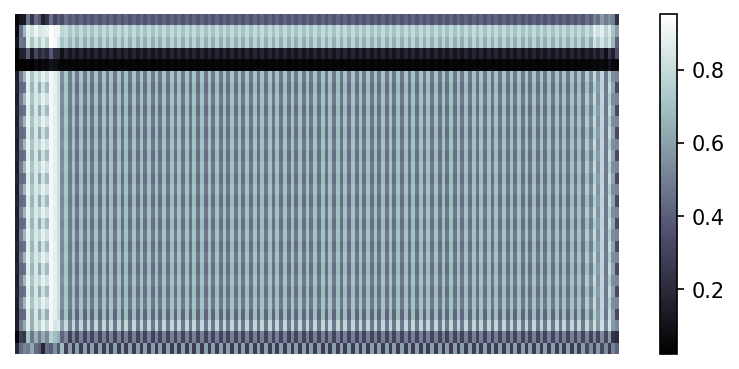

In [54]:
fig = plt.figure(figsize=(7,3), dpi=150)
plt.imshow(res_map_bl[1], cmap=plt.get_cmap('bone'))
plt.axis('off')
plt.colorbar()

## Mirror Padding

In [ ]:
with graph.as_default():
  with tf.compat.v1.Session() as sess:
    res_map_mirror = calc_map(sess, img[0], [0, 0, 24, 8], 8, 24, 128, print_progress=False)

(-0.5, 1279.5, 719.5, -0.5)

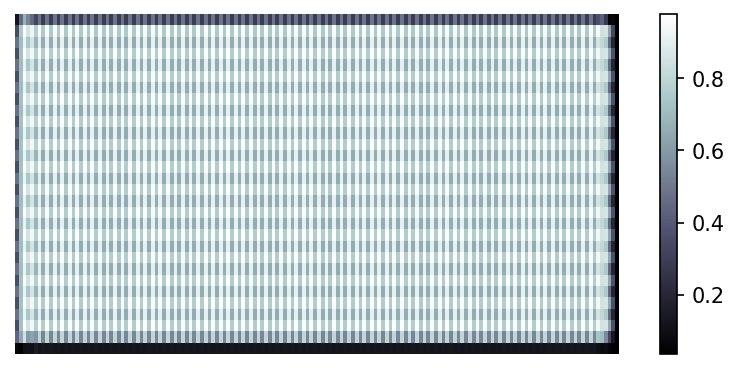

In [55]:
fig = plt.figure(figsize=(7,3), dpi=150)
plt.imshow(res_map_mirror[1], cmap=plt.get_cmap('bone'))
plt.colorbar()
plt.axis('off')

